# Diversity Condition Violated Correct Model

This is a notebook that performs the experiment when the diversity condition is violated and we select a correct model to adjust for that.

- $p(\tilde{z}|z) = \delta(u - u') \frac{e^{\kappa}\tilde{z}^{T}z}{\int_{W(z)}e^{\kappa z^{T}z'}dz'}$ - model conditional density
- $q_{h}(\tilde{z}|z) = \delta(u-u') \frac{e^{\frac{1}{\tau} h(\tilde{z})^{T}h(z)}}{\int_{W(z)}e^{\frac{1}{\tau}h(z)^{T}h(z')}dz'}$ - Model conditional density

The loss function in this setup will be the following:

$\mathcal{L} = \mathbb{E}_{(z, \tilde{z}) \sim p(z, \tilde{z}), \{z^{-}_{i}\} \sim U(\mathcal{W}(z)) }[- \log(\frac{e^{\frac{1}{\tau}h(\tilde{z})^{T}h(z)}}{\Sigma_{i=1}^{M}e^{\frac{1}{\tau} h(\tilde{z})^{T}h(z^{-}_{i})}})]$

The plan is to do the experiments with the following data generating processess:

- 

In [57]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
from torch import functional

from spaces import NSphereSpace
from visualization_utils.spheres import visualize_spheres_side_by_side
import matplotlib.pyplot as plt
from evals.disentanglement import linear_disentanglement, permutation_disentanglement

full_sphere = NSphereSpace(3)
sub_sphere = NSphereSpace(2)

class SimCLRAdjusted(nn.Module):
    def __init__(self, d, d_fix, neg_samples, decoder, encoder, sample_pair, sample_negative, tau=0.1, device='cpu'):
        super(SimCLRAdjusted, self).__init__()
        self.d = d
        self.d_fix = d_fix
        self.neg_samples = neg_samples
        self.tau = tau
        self.decoder = decoder
        self.encoder = encoder
        self.sample_pair = sample_pair
        self.sample_negative = sample_negative
        self.device = device
        self.decoder.to(self.device)
        self.encoder.to(self.device)

    def loss(self, Z_enc, Z_pos_enc, Z_neg_enc):
        neg = torch.logsumexp((Z_enc.unsqueeze(1) * Z_neg_enc).sum(dim=2) / self.tau, dim=1).mean()
        pos = - (Z_enc * Z_pos_enc).sum(dim=1).mean() / self.tau

        return neg + pos, neg, pos

    def train(self, batch_size, iterations):
        for p in self.decoder.parameters():
            p.requires_grad = False

        adam = torch.optim.Adam(self.encoder.parameters(), lr=1e-4)

        h = lambda latent: self.encoder(self.decoder(latent.to(self.device)))

        # --- Evaluation on latent space before training
        control_latent = self.sample_uniform(batch_size).to(self.device)

        linear = linear_disentanglement(control_latent, control_latent)
        print("Linear control score:", linear[0][0])

        perm = permutation_disentanglement(control_latent, control_latent)
        print("Permutation control score:", perm[0][0])

        for i in range(iterations):
            z, z_sim = self.sample_pair(batch_size)

            z = z.to(self.device)
            z_sim = z_sim.to(self.device)
            z_neg = self.sample_negative(batch_size).to(self.device)

            z_enc = h(z)
            z_enc_sim = h(z_sim)
            z_enc_neg = h(z_neg)

            loss_result, neg, pos = self.loss(z_enc, z_enc_sim, z_enc_neg)

            loss_result.backward()
            adam.step()

            if i % 250 == 1:
                lin_dis, _ = linear_disentanglement(z.cpu(), z_enc.cpu())
                lin_score, _ = lin_dis

                perm_dis, _ = permutation_disentanglement(z.cpu(), z_enc.cpu())
                perm_score, _ = perm_dis

                print('Loss:', loss_result, 'Samples processed:', i,
                      "linear disentanglement:", lin_score,
                      'permutation disentanglement:', perm_score,
                      'Negative:', neg.item(),
                      'Positive:', pos.item())
                
        self.encoder.eval()

        return self.encoder

d_fix = 1
d = 3
N = 6000
M = 6000
kappa = 10
tau = 1 / kappa

Z = torch.randn(N, d)
Z = Z / Z.norm(dim=1, keepdim=True)

# Sampling negative samples in the case where the model of the latent space has violated diversity condition, but our model adjusts for that
def sample_negative_samples(Z, M):
    z_fixed = Z[:, :d_fix]

    radii = torch.sqrt(1 - (z_fixed ** 2).sum(dim=1)) # Radius of the sub-sphere
    neg_samples = torch.randn(Z.shape[0], M, d - d_fix)

    neg_samples = neg_samples / (neg_samples.norm(dim=2, keepdim=True) + 1e-8) # Normalize the samples + add some margin for error
    neg_samples = neg_samples * radii.view(-1, 1, 1)

    return torch.cat((z_fixed.unsqueeze(1).expand(-1, M, -1), neg_samples), dim=2)


def sample_conditional_with_dims_fixed(z, batch, u_dim):
    u = z[:,:u_dim]
    v = z[:,u_dim:]

    v_norm = torch.nn.functional.normalize(v, dim=-1, p=2)
    aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, batch) * torch.norm(v, p=2, dim=-1, keepdim=True)

    return torch.cat((u, aug_samples_v), dim=-1)


def sample_pair_with_fixed_dimension(batch, u_dim):
    z = full_sphere.uniform(batch) # (N, 3)
    
    return z, sample_conditional_with_dims_fixed(z, batch, u_dim)


sample_uniform_fixed = lambda batch: full_sphere.uniform(batch)
sample_pair_fixed = lambda batch: sample_pair_with_fixed_dimension(batch, d_fix)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Visualizing the sampling processess

- Uniform Sampling
- Conditional Sampling
- Negative sample sampling

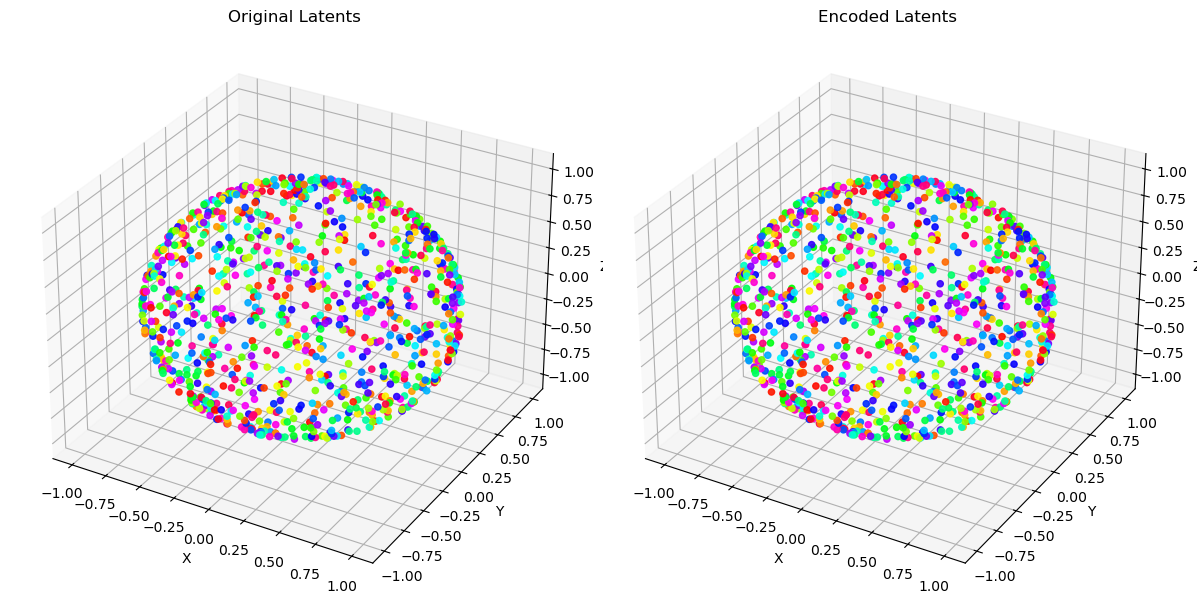

In [11]:
## Uniform sampling

s = full_sphere.uniform(1000)

visualize_spheres_side_by_side(plt, s, s)

tensor([-0.3158,  0.6630,  0.6787])


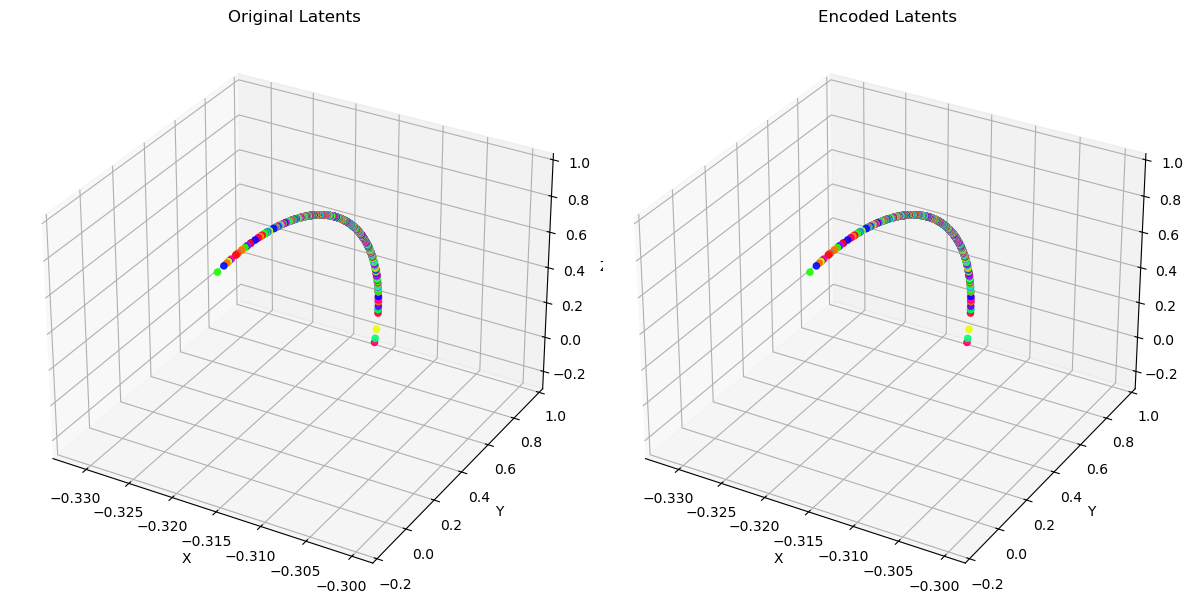

In [65]:
## Visualizing similar sample sampling

z = sample_uniform_fixed(1).squeeze(0)

print(z)

u = z[:1]
v = z[1:]

v_norm = torch.nn.functional.normalize(v, dim=-1, p=2)
aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, 1000) * torch.norm(v, p=2, dim=-1, keepdim=True)

z_aug = torch.cat((u.expand(1000, 1), aug_samples_v), dim=-1)

visualize_spheres_side_by_side(plt, z_aug, z_aug)

z shape: tensor([[ 0.3880, -0.0674, -0.9192]])
SHAPE OF NEGATIVE SAMPLES torch.Size([1000, 3])
MAX tensor(1.0000)
MIN tensor(1.0000)


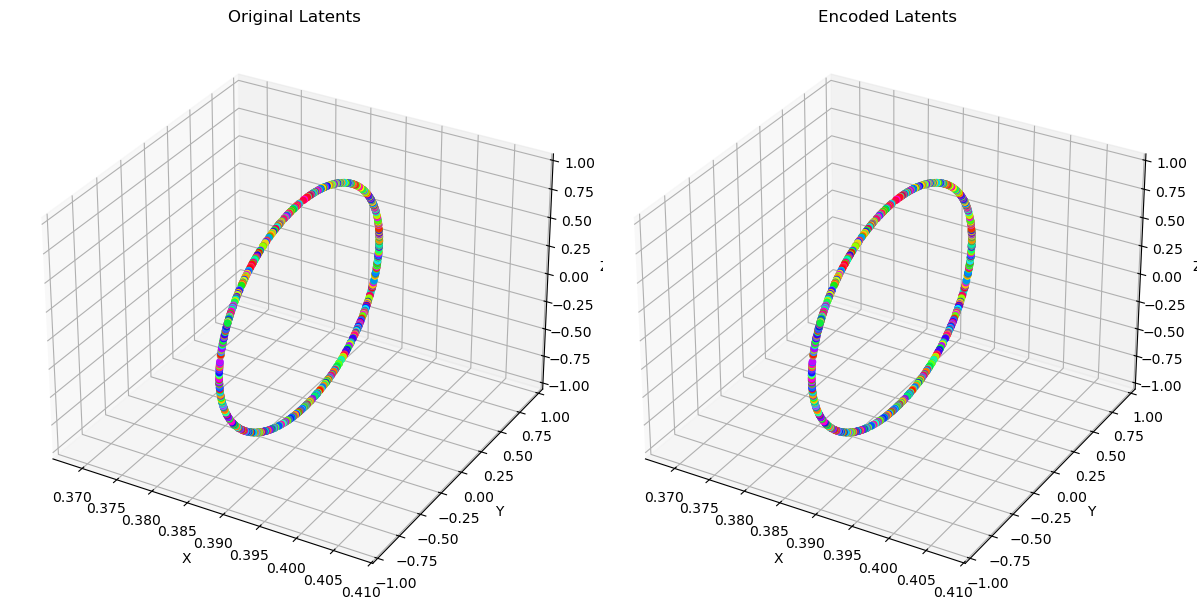

In [64]:
## Visualizing the negative sample sampling

z = sample_uniform_fixed(1)

print("z shape:", z)

negative_samples = sample_negative_samples(z, 1000).squeeze(0)

print('SHAPE OF NEGATIVE SAMPLES', negative_samples.shape)
print("MAX", (negative_samples ** 2).sum(dim=1).max())
print("MIN", (negative_samples ** 2).sum(dim=1).min())

visualize_spheres_side_by_side(plt, negative_samples, negative_samples)